# VAE and VSC for Cell Images

In [1]:
import torch
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import sys

from torch import cuda
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils import data
from torchvision.utils import save_image
from torch.utils.tensorboard import SummaryWriter
from PIL import Image


In [2]:
sys.path.insert(0, '../scripts')

from vsc import VSC
from vae import VAE

In [3]:
data_dir = '../../../Data/'
results_dir = '../../../results/VSC/z256a0.5c50b1e100'
tensorboard_dir = '../../../tb/VSC'
metadata_dir = '../../../metadata/'
batch_size = 128

tb_writer = SummaryWriter(tensorboard_dir)

torch.manual_seed(22)
device = torch.device("cuda" if cuda.is_available() else "cpu")
print(device)

cuda


The following code is a utility to load and split the data given the path where the data is stored, pytorch keeps the folder names as labes as if it was a classification task, but they can just be ignored when using the data loaders. Since the task at hand is from a very specific domain (biology and cell images) the normalization values that are often used for computer vision tasks cannot be used. The mean and std used to normalize the dataset was pre computed from a small sample of the dataset and might not be accurate, but it seems to work well right now

In [4]:
def split_data(data_dir, n_split=0.2, batch_size=256):
    
    pin_memory = cuda.is_available()
    workers = 4
    
    # Create training and validation datasets
    image_dataset = datasets.ImageFolder(data_dir, transform=transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        transforms.Normalize((0.0302, 0.0660, 0.0518), (0.0633, 0.0974, 0.0766))
    ]))
    # Create training and validation dataloaders
    total = len(image_dataset)
    n_test = int(total * n_split)
    n_train = total - n_test 
    train_set, test_set = data.random_split(image_dataset, (n_train, n_test))
    n_val = int(len(train_set) * n_split)
    n_train = len(train_set) - n_val
    train_set, val_set = data.random_split(train_set, (n_train, n_val))  
    
    print('Train split: ', len(train_set))
    print('Val split: ', len(val_set))
    print('Test split: ', len(test_set))
    
    train_loader = data.DataLoader(
      train_set,
      batch_size=batch_size,
      num_workers = workers,
      shuffle=True,
      pin_memory=pin_memory
    )
    val_loader = data.DataLoader(
      val_set,
      batch_size=batch_size,
      num_workers = workers,
      shuffle=True,
      pin_memory=pin_memory
    )
    test_loader = data.DataLoader(
      test_set,
      batch_size=batch_size,
      num_workers = workers,
      shuffle=True,
      pin_memory=pin_memory
    )
    return train_loader, val_loader, test_loader, image_dataset.class_to_idx

Helper function to view tensors as a plot

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.0302, 0.0660, 0.0518])
    std = np.array([0.0633, 0.0974, 0.0766])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

In [6]:
def grid_and_unnormalize(batch_tensor):
    grid = torchvision.utils.make_grid(batch_tensor)
    image = grid.numpy().transpose((1, 2, 0))
    mean = np.array([0.0302, 0.0660, 0.0518])
    std = np.array([0.0633, 0.0974, 0.0766])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    return image

## Variational AutoEncoder

The previous work this is based on had an specific VAE architecture implemented in TensorFlow, the first step was to migrate that NN to Pytorch keeping the same layers and the same operations that were done in the encoder and autoencoder, as well as to keep the same loss fuction

In [7]:
# With new stuff we just have to import the files
import sys
sys.path.insert(0, '../scripts/')
import vae
import vsc

From what I've seen MSE and KLD and somewhat incompatible depending on how the scores are aggregated. It either has to be sum or mean, choosing different aggregation techniques results in the difference between scores being too different and the NN will end up optimizing the one that has the bigger impact. Current solution is B-Vae where a B parameter is added to the KLD as to control how much importance it has in the loss function; KLD and MSE are aggregated by sum.

In [8]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar, epoch_n=False):
    
    # mse = F.mse_loss(recon_x, x, reduction='mean')
     
    mse = torch.mean(torch.sum((x - recon_x).pow(2), dim=(1,2,3)))
    
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    
    #kld = torch.mean(-0.5 * torch.sum(1 + torch.log(1e-10 + sigma.pow(2)) - mu.pow(2) - sigma.pow(2)))
    #kld = torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), axis=1))
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) * beta
    
    loss = mse + kld
    return loss, mse, kld

Helpers for the model training and testing loop 

In [9]:
def train(epoch, train_loader):
    model.train()
    train_loss = 0
    train_mse = 0
    train_kld = 0
    train_slab = 0
    train_spike = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, gamma = model(data)
        loss, mse, kld, slab, spike = loss_function(recon_batch, data, mu, logvar, gamma, alpha=alpha, beta=beta)
        
        loss.backward()
        optimizer.step()
        
        current_batch_size = len(data)
        train_loss += loss.item() * current_batch_size
        train_mse += mse.item() * current_batch_size
        train_kld += kld.item()
        train_slab += slab.item()
        train_spike += spike.item()
        
        if batch_idx % (int(len(train_loader) / 4)) == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item()))

    datapoints = len(train_loader.dataset)
    avg_loss = train_loss/datapoints
    avg_mse = train_mse/datapoints
    avg_kld = train_kld/(beta * len(train_loader))
    avg_slab = train_slab/(beta * len(train_loader))
    avg_spike = train_spike/(beta * len(train_loader))

    print('====> Epoch: {} Average loss: {:.8f}'.format(epoch, avg_loss))
    print('*** Avg MSE: {:.4f}'.format(avg_mse))
    print('*** Avg KLD: {:.8f}'.format(avg_kld * beta))
    print('* Avg Slab: {:.8f}'.format(avg_slab * beta))
    print('* Avg Spike: {:.8f}'.format(avg_spike * beta))
    return avg_loss, avg_mse, avg_kld, avg_slab, avg_spike

In [10]:
def test(epoch, test_loader):
    model.eval()
    test_loss = 0
    test_mse = 0
    test_kld = 0
    test_slab = 0
    test_spike = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar, gamma = model(data)
            loss, mse, kld, slab, spike = loss_function(recon_batch, data, mu, logvar, gamma, alpha=alpha, beta=beta)

            current_batch_size = data.size(0)
            test_loss += loss.item() * current_batch_size
            test_mse += mse.item() * current_batch_size
            test_kld += kld.item()
            test_slab += slab.item()
            test_spike += spike.item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n], recon_batch[:n]]).cpu()
                image = grid_and_unnormalize(comparison)
                comparison = torchvision.utils.make_grid(comparison)
                imshow(comparison)
                
                tb_writer.add_image("Reconstruction/recon_"+str(epoch), image, epoch, dataformats='HWC')
                
                plt.savefig(results_dir + 'reconstruction_' + str(epoch) + '.png')
                plt.close()
                #save_image(comparison, results_dir + 'reconstruction_' + str(epoch) + '.tif')

    datapoints = len(test_loader.dataset)
    test_loss /= datapoints
    test_mse /= datapoints
    test_kld /= (beta * len(test_loader))
    test_slab /= (beta * len(test_loader))
    test_spike /= (beta * len(test_loader))
    print('====> Test set loss: {:.8f}'.format(test_loss))
    print('*** Avg MSE: {:.8f}'.format(test_mse))
    print('*** Avg KLD: {:.8f}'.format(test_kld))
    print('* Avg Slab: {:.8f}'.format(test_slab * beta))
    print('* Avg Spike: {:.8f}'.format(test_spike * beta))
    return test_loss, test_mse, test_kld, test_slab, test_spike

In [11]:
def get_time_in_hours(seconds):
    hours = seconds // 3600
    remaining_time = seconds % 3600
    minutes = remaining_time // 60
    seconds = remaining_time % 60
    
    return hours, minutes, seconds

### Training
The training of the migrated VAE starts here

In [12]:
train_data, val_data, test_data, label_mapping = split_data(data_dir=data_dir, batch_size=batch_size)

Train split:  97014
Val split:  24253
Test split:  30316


In [13]:
alpha = 0.5
beta = 1
c = 50
model = vsc.VSC(256, c).to(device)
loss_function = vsc.loss_function
model

VSC(
  (encoder_conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_conv2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_conv3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten()
  (encoder_fc1): Linear(in_features=4608, out_features=256, bias=True)
  (encoder_fc2): Linear(in_features=4608, out_features=256, bias=True)
  (encoder_fc3): Linear(in_features=4608, out_features=256, bias=True)
  (encoder_sigmoid): Sigmoid()
  (reparam_sigmoid): Sigmoid()
  (decoder_fc1): Sequential(
    (0): Linear(in_features=256, out_

In [13]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_trace = {
    'loss': [],
    'mse': [],
    'kld': [],
    'slab': [],
    'spike': []
}

val_trace = {
    'loss': [],
    'mse': [],
    'kld': [],
    'slab': [],
    'spike': []
}
epochs = 100
since = time.time()
for epoch in range(1, epochs + 1):
        train_loss, train_mse, train_kld, train_slab, train_spike = train(epoch, train_data)
        train_trace['loss'].append(train_loss)
        train_trace['mse'].append(train_mse)
        train_trace['kld'].append(train_kld)
        train_trace['slab'].append(train_slab)
        train_trace['spike'].append(train_spike)

        val_loss, val_mse, val_kld, val_slab, val_spike = test(epoch, val_data)
        val_trace['loss'].append(val_loss)
        val_trace['mse'].append(val_mse)
        val_trace['kld'].append(val_kld)
        val_trace['slab'].append(val_slab)
        val_trace['spike'].append(val_spike)
        c += 1
        print('Updating C. c=',c)
        model.update_c(c)
        tb_writer.add_scalars('Loss/Total', {
            'train': train_loss,
            'test': val_loss
        }, epoch)
        
        tb_writer.add_scalars('Loss/MSE', {
            'train': train_mse,
            'test': val_mse
        }, epoch)
        
        tb_writer.add_scalars('Loss/KLD', {
            'train': train_kld,
            'test': val_kld
        }, epoch)
        
        tb_writer.add_scalars('Loss/Slab', {
            'train': train_slab,
            'test': val_slab
        }, epoch)
        
        tb_writer.add_scalars('Loss/Spike', {
            'train': train_spike,
            'test': val_spike
        }, epoch)
        
        with torch.no_grad():
            sample = torch.randn(4, 256).to(device)
            sample = model.decode(sample).cpu()
            image = grid_and_unnormalize(sample)
            sample = torchvision.utils.make_grid(sample)
            tb_writer.add_image("Sample/sample_"+str(epoch), image, epoch, dataformats='HWC')
            imshow(sample)
            plt.savefig(results_dir + 'sample_' + str(epoch) + '.png')
            plt.close()
            #save_image(sample, results_dir + 'sample_' + str(epoch) + '.tif')
        
        epoch_time = time.time() - since
        e_hours, e_minutes, e_seconds = get_time_in_hours(epoch_time)
        print('Time elapsed {:.0f}h {:.0f}m {:.0f}s'.format(e_hours, e_minutes, e_seconds))

Train Epoch: 1 [0/97014 (0%)]	Loss: 37017.648438
Train Epoch: 1 [24192/97014 (25%)]	Loss: 21007.357422
Train Epoch: 1 [48384/97014 (50%)]	Loss: 21298.884766
Train Epoch: 1 [72576/97014 (75%)]	Loss: 18691.570312
Train Epoch: 1 [96768/97014 (100%)]	Loss: 21001.023438
====> Epoch: 1 Average loss: 20906.97813798
*** Avg MSE: 18479.8748
*** Avg KLD: 2427.07099298
* Avg Slab: 2318.92895878
* Avg Spike: 108.14203207
====> Test set loss: 18291.05401676
*** Avg MSE: 15645.66492547
*** Avg KLD: 2641.70265985
* Avg Slab: 2529.93645598
* Avg Spike: 111.76619747
Updating C. c= 51
Time elapsed 0h 29m 21s
Train Epoch: 2 [0/97014 (0%)]	Loss: 19559.878906
Train Epoch: 2 [24192/97014 (25%)]	Loss: 16977.794922
Train Epoch: 2 [48384/97014 (50%)]	Loss: 15758.096680
Train Epoch: 2 [72576/97014 (75%)]	Loss: 17221.318359
Train Epoch: 2 [96768/97014 (100%)]	Loss: 14773.423828
====> Epoch: 2 Average loss: 17563.75775438
*** Avg MSE: 14952.6706
*** Avg KLD: 2611.06296767
* Avg Slab: 2505.66817569
* Avg Spike: 10

Train Epoch: 15 [0/97014 (0%)]	Loss: 18120.394531
Train Epoch: 15 [24192/97014 (25%)]	Loss: 17039.121094
Train Epoch: 15 [48384/97014 (50%)]	Loss: 16298.098633
Train Epoch: 15 [72576/97014 (75%)]	Loss: 14527.685547
Train Epoch: 15 [96768/97014 (100%)]	Loss: 15661.637695
====> Epoch: 15 Average loss: 15378.28015721
*** Avg MSE: 12433.1572
*** Avg KLD: 2945.08080700
* Avg Slab: 2876.85161113
* Avg Spike: 68.22919664
====> Test set loss: 15423.51753130
*** Avg MSE: 12434.41704204
*** Avg KLD: 2984.60863294
* Avg Slab: 2914.99755667
* Avg Spike: 69.61107379
Updating C. c= 65
Time elapsed 0h 59m 16s
Train Epoch: 16 [0/97014 (0%)]	Loss: 14195.844727
Train Epoch: 16 [24192/97014 (25%)]	Loss: 15373.802734
Train Epoch: 16 [48384/97014 (50%)]	Loss: 17403.238281
Train Epoch: 16 [72576/97014 (75%)]	Loss: 14568.152344
Train Epoch: 16 [96768/97014 (100%)]	Loss: 17776.468750
====> Epoch: 16 Average loss: 15342.63757287
*** Avg MSE: 12393.9346
*** Avg KLD: 2948.66638699
* Avg Slab: 2880.06613505
* Avg

====> Test set loss: 15146.42982094
*** Avg MSE: 12162.77623596
*** Avg KLD: 2979.82986354
* Avg Slab: 2914.58128341
* Avg Spike: 65.24857762
Updating C. c= 78
Time elapsed 1h 40m 6s
Train Epoch: 29 [0/97014 (0%)]	Loss: 16493.714844
Train Epoch: 29 [24192/97014 (25%)]	Loss: 12898.200195
Train Epoch: 29 [48384/97014 (50%)]	Loss: 14619.734375
Train Epoch: 29 [72576/97014 (75%)]	Loss: 16818.214844
Train Epoch: 29 [96768/97014 (100%)]	Loss: 14674.890625
====> Epoch: 29 Average loss: 15074.52598232
*** Avg MSE: 12075.0677
*** Avg KLD: 2999.44637957
* Avg Slab: 2932.70574967
* Avg Spike: 66.74062978
====> Test set loss: 15129.50015671
*** Avg MSE: 12109.71491506
*** Avg KLD: 3015.86286300
* Avg Slab: 2947.59522512
* Avg Spike: 68.26764416
Updating C. c= 79
Time elapsed 1h 42m 17s
Train Epoch: 30 [0/97014 (0%)]	Loss: 13685.613281
Train Epoch: 30 [24192/97014 (25%)]	Loss: 12644.875000
Train Epoch: 30 [48384/97014 (50%)]	Loss: 15682.808594
Train Epoch: 30 [72576/97014 (75%)]	Loss: 14498.663086


Train Epoch: 42 [96768/97014 (100%)]	Loss: 14774.058594
====> Epoch: 42 Average loss: 14912.02343392
*** Avg MSE: 11879.7278
*** Avg KLD: 3032.23185178
* Avg Slab: 2966.88772140
* Avg Spike: 65.34413323
====> Test set loss: 15009.78414856
*** Avg MSE: 11970.28487093
*** Avg KLD: 3034.96416979
* Avg Slab: 2969.80872225
* Avg Spike: 65.15544393
Updating C. c= 92
Time elapsed 2h 10m 38s
Train Epoch: 43 [0/97014 (0%)]	Loss: 14288.077148
Train Epoch: 43 [24192/97014 (25%)]	Loss: 16502.337891
Train Epoch: 43 [48384/97014 (50%)]	Loss: 15113.603516
Train Epoch: 43 [72576/97014 (75%)]	Loss: 16307.814453
Train Epoch: 43 [96768/97014 (100%)]	Loss: 13636.086914
====> Epoch: 43 Average loss: 14896.19073228
*** Avg MSE: 11856.6451
*** Avg KLD: 3039.52089238
* Avg Slab: 2975.39787321
* Avg Spike: 64.12302047
====> Test set loss: 14971.71839296
*** Avg MSE: 11963.47823924
*** Avg KLD: 3003.67573242
* Avg Slab: 2938.92812693
* Avg Spike: 64.74760655
Updating C. c= 93
Time elapsed 2h 12m 49s
Train Epoch

Train Epoch: 56 [0/97014 (0%)]	Loss: 14708.035156
Train Epoch: 56 [24192/97014 (25%)]	Loss: 15673.312500
Train Epoch: 56 [48384/97014 (50%)]	Loss: 14088.327148
Train Epoch: 56 [72576/97014 (75%)]	Loss: 14502.925781
Train Epoch: 56 [96768/97014 (100%)]	Loss: 15104.849609
====> Epoch: 56 Average loss: 14800.55138134
*** Avg MSE: 11738.6742
*** Avg KLD: 3061.85790082
* Avg Slab: 2998.66837812
* Avg Spike: 63.18952216
====> Test set loss: 14875.96415013
*** Avg MSE: 11777.56945734
*** Avg KLD: 3094.82853104
* Avg Slab: 3031.71492470
* Avg Spike: 63.11360249
Updating C. c= 106
Time elapsed 2h 41m 38s
Train Epoch: 57 [0/97014 (0%)]	Loss: 15593.947266
Train Epoch: 57 [24192/97014 (25%)]	Loss: 13270.352539
Train Epoch: 57 [48384/97014 (50%)]	Loss: 14526.184570
Train Epoch: 57 [72576/97014 (75%)]	Loss: 15323.293945
Train Epoch: 57 [96768/97014 (100%)]	Loss: 16340.992188
====> Epoch: 57 Average loss: 14802.19732407
*** Avg MSE: 11736.6337
*** Avg KLD: 3065.54087326
* Avg Slab: 3001.36274337
* Av

====> Test set loss: 14796.43687363
*** Avg MSE: 11783.30679327
*** Avg KLD: 3008.22178248
* Avg Slab: 2947.13605186
* Avg Spike: 61.08573610
Updating C. c= 119
Time elapsed 3h 9m 52s
Train Epoch: 70 [0/97014 (0%)]	Loss: 14484.918945
Train Epoch: 70 [24192/97014 (25%)]	Loss: 12896.264648
Train Epoch: 70 [48384/97014 (50%)]	Loss: 13992.722656
Train Epoch: 70 [72576/97014 (75%)]	Loss: 16113.572266
Train Epoch: 70 [96768/97014 (100%)]	Loss: 13395.731445
====> Epoch: 70 Average loss: 14752.93156565
*** Avg MSE: 11661.3831
*** Avg KLD: 3091.50624459
* Avg Slab: 3026.30355924
* Avg Spike: 65.20268532
====> Test set loss: 14813.99387399
*** Avg MSE: 11748.03343538
*** Avg KLD: 3061.13494488
* Avg Slab: 2999.37885999
* Avg Spike: 61.75608913
Updating C. c= 120
Time elapsed 3h 12m 1s
Train Epoch: 71 [0/97014 (0%)]	Loss: 15454.894531
Train Epoch: 71 [24192/97014 (25%)]	Loss: 15716.151367
Train Epoch: 71 [48384/97014 (50%)]	Loss: 14686.390625
Train Epoch: 71 [72576/97014 (75%)]	Loss: 14286.387695

Train Epoch: 83 [96768/97014 (100%)]	Loss: 14921.391602
====> Epoch: 83 Average loss: 14681.50243091
*** Avg MSE: 11582.7623
*** Avg KLD: 3098.71439380
* Avg Slab: 3036.31736413
* Avg Spike: 62.39703024
====> Test set loss: 14784.47699709
*** Avg MSE: 11639.45077767
*** Avg KLD: 3140.66270109
* Avg Slab: 3080.73577945
* Avg Spike: 59.92691884
Updating C. c= 133
Time elapsed 3h 40m 37s
Train Epoch: 84 [0/97014 (0%)]	Loss: 15155.482422
Train Epoch: 84 [24192/97014 (25%)]	Loss: 13640.201172
Train Epoch: 84 [48384/97014 (50%)]	Loss: 13954.852539
Train Epoch: 84 [72576/97014 (75%)]	Loss: 14978.799805
Train Epoch: 84 [96768/97014 (100%)]	Loss: 14178.613281
====> Epoch: 84 Average loss: 14682.73515988
*** Avg MSE: 11575.0539
*** Avg KLD: 3107.63257029
* Avg Slab: 3045.94619373
* Avg Spike: 61.68637762
====> Test set loss: 14775.46724495
*** Avg MSE: 11701.27071784
*** Avg KLD: 3069.67086631
* Avg Slab: 3008.81651162
* Avg Spike: 60.85435233
Updating C. c= 134
Time elapsed 3h 42m 47s
Train Epo

Train Epoch: 97 [0/97014 (0%)]	Loss: 14724.166992
Train Epoch: 97 [24192/97014 (25%)]	Loss: 14182.510742
Train Epoch: 97 [48384/97014 (50%)]	Loss: 16020.479492
Train Epoch: 97 [72576/97014 (75%)]	Loss: 15083.503906
Train Epoch: 97 [96768/97014 (100%)]	Loss: 14908.207031
====> Epoch: 97 Average loss: 14654.03260177
*** Avg MSE: 11530.5631
*** Avg KLD: 3123.42666505
* Avg Slab: 3055.98022010
* Avg Spike: 67.44644486
====> Test set loss: 14778.57538460
*** Avg MSE: 11586.80821046
*** Avg KLD: 3187.61477822
* Avg Slab: 3122.15053325
* Avg Spike: 65.46424430
Updating C. c= 147
Time elapsed 4h 11m 10s
Train Epoch: 98 [0/97014 (0%)]	Loss: 14053.624023
Train Epoch: 98 [24192/97014 (25%)]	Loss: 14818.890625
Train Epoch: 98 [48384/97014 (50%)]	Loss: 13007.724609
Train Epoch: 98 [72576/97014 (75%)]	Loss: 16825.968750
Train Epoch: 98 [96768/97014 (100%)]	Loss: 13624.227539
====> Epoch: 98 Average loss: 14651.23226573
*** Avg MSE: 11535.4167
*** Avg KLD: 3115.77290992
* Avg Slab: 3049.52298014
* Av

In [14]:
def plot_loss(train_data, val_data, epochs, xlabel, ylabel, title):
    plt.figure(figsize=(10,10))
    
    min_train = int(min(train_data))
    max_train = int(max(train_data))
    min_val = int(min(val_data))
    max_val = int(max(val_data))
    
    low_bound = min(min_train, min_val)
    up_bound = max(max_train, max_val)
    
    plt.plot(train_data, label='train')
    plt.plot(val_data, label='test')
    plt.xticks(np.arange(0, epochs+1, int(epochs/20)))
    plt.yticks(np.arange(low_bound, up_bound*1.01, int((1.1*up_bound - 1.1*low_bound) / 20)))
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

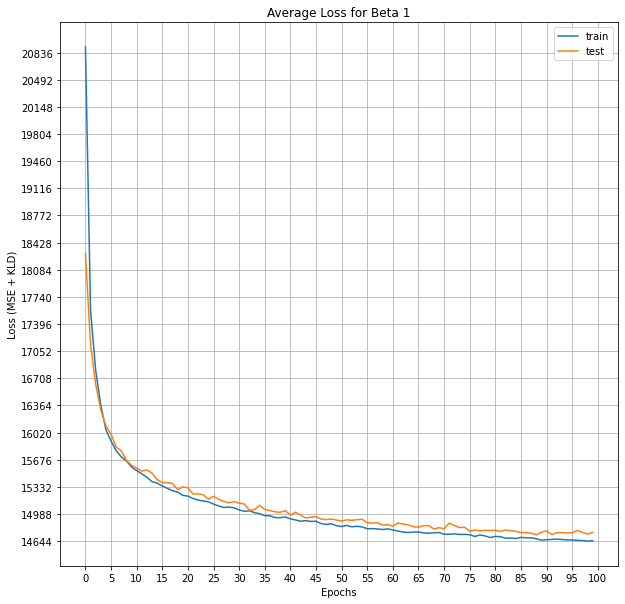

In [15]:
plot_loss(train_trace['loss'], val_trace['loss'], epochs, 'Epochs', "Loss (MSE + KLD)", "Average Loss for Beta " + str(beta))

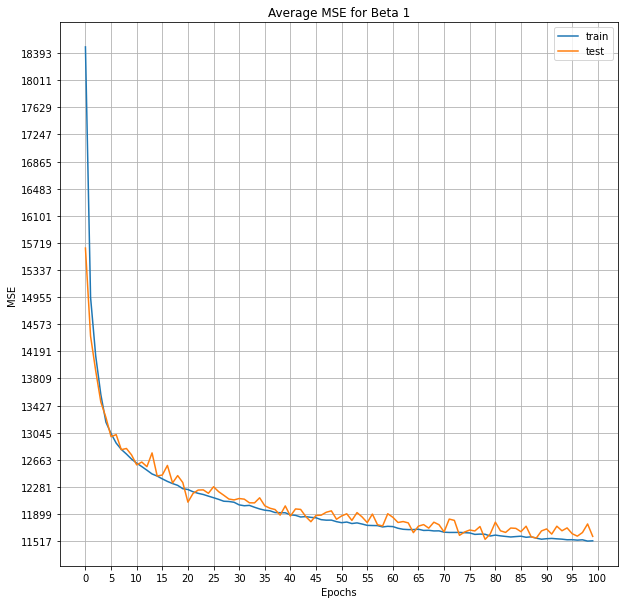

In [16]:
plot_loss(train_trace['mse'], val_trace['mse'], epochs, 'Epochs', "MSE", "Average MSE for Beta " + str(beta))

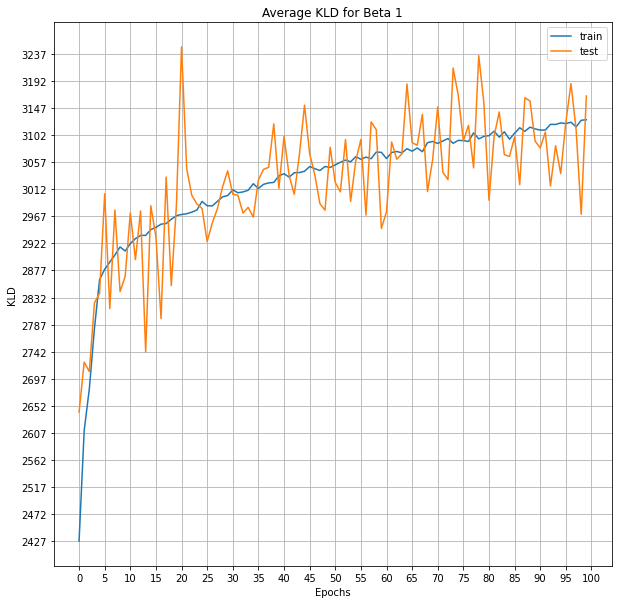

In [17]:
plot_loss(train_trace['kld'], val_trace['kld'], epochs, 'Epochs', "KLD", "Average KLD for Beta " + str(beta))

In [18]:
torch.save(model.state_dict(), results_dir + 'vsc.pth')

In [14]:
model = VSC(256, 150)
model.load_state_dict(torch.load(results_dir + 'vsc.pth'))
model.to(device)
model.eval()

VSC(
  (encoder_conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_conv2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_conv3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten()
  (encoder_fc1): Linear(in_features=4608, out_features=256, bias=True)
  (encoder_fc2): Linear(in_features=4608, out_features=256, bias=True)
  (encoder_fc3): Linear(in_features=4608, out_features=256, bias=True)
  (encoder_sigmoid): Sigmoid()
  (reparam_sigmoid): Sigmoid()
  (decoder_fc1): Sequential(
    (0): Linear(in_features=256, out_

## Evaluation

In [17]:
metadata = pd.read_csv(metadata_dir + 'compound_to_cell.csv')
metadata['Image_FileName_DAPI'] = metadata['Image_FileName_DAPI'].apply(lambda x: x.split('.tif')[0])
metadata.head(5)

,TableNumber,ImageNumber,Image_FileName_DAPI,Image_PathName_DAPI,Image_FileName_Tubulin,Image_PathName_Tubulin,Image_FileName_Actin,Image_PathName_Actin,Image_Metadata_Plate_DAPI,Image_Metadata_Well_DAPI,Replicate,Image_Metadata_Compound,Image_Metadata_Concentration
0,4,233,G10_s1_w1BEDC2073-A983-4B98-95E9-84466707A25D,Week4/Week4_27481,G10_s1_w2DCEC82F3-05F7-4F2F-B779-C5DF9698141E.tif,Week4/Week4_27481,G10_s1_w43CD51CBC-2370-471F-BA01-EE250B14B3C8.tif,Week4/Week4_27481,Week4_27481,G10,1,5-fluorouracil,0.003
1,4,234,G10_s2_w11C3B9BCC-E48F-4C2F-9D31-8F46D8B5B972,Week4/Week4_27481,G10_s2_w2570437EF-C8DC-4074-8D63-7FA3A7271FEE.tif,Week4/Week4_27481,G10_s2_w400B21F33-BDAB-4363-92C2-F4FB7545F08C.tif,Week4/Week4_27481,Week4_27481,G10,1,5-fluorouracil,0.003
2,4,235,G10_s3_w1F4FCE330-C71C-4CA3-9815-EAF9B9876EB5,Week4/Week4_27481,G10_s3_w2194A9AC7-369B-4D84-99C0-DA809B0042B8.tif,Week4/Week4_27481,G10_s3_w4E0452054-9FC1-41AB-8C5B-D0ACD058991F.tif,Week4/Week4_27481,Week4_27481,G10,1,5-fluorouracil,0.003
3,4,236,G10_s4_w1747818B4-FFA7-40EE-B0A0-6A5974AF2644,Week4/Week4_27481,G10_s4_w298D4652F-B5BF-49F2-BE51-8149DF83EAFD.tif,Week4/Week4_27481,G10_s4_w42648D36D-6B77-41CD-B520-6E4C533D9ABC.tif,Week4/Week4_27481,Week4_27481,G10,1,5-fluorouracil,0.003
4,4,473,G10_s1_w10034568D-CC12-43C3-93A9-DC3782099DD3,Week4/Week4_27521,G10_s1_w2A29ED14B-952C-4BA1-89B9-4F92B6DADEB4.tif,Week4/Week4_27521,G10_s1_w4DAA2E9D1-F6E9-45FA-ADC0-D341B647A680.tif,Week4/Week4_27521,Week4_27521,G10,2,5-fluorouracil,0.003


In [18]:
test_z = None
test_labels = None
for data, labels in test_data:
    data = data.to(device)
    encoded = model.encode(data)
    batch_z = model.reparameterize(*encoded).cpu().detach()
    if test_z is not None:
        test_z = torch.cat((test_z, batch_z), dim=0)
        test_labels = torch.cat((test_labels, labels))
    else:
        test_z = batch_z
        test_labels = labels


In [19]:
compound_folder = metadata[['Image_FileName_DAPI', 'Image_Metadata_Compound']].sort_values('Image_FileName_DAPI')
cf_id = compound_folder['Image_FileName_DAPI'].apply(lambda x: int(label_mapping.get(x, -1)))
compound_folder['id'] = cf_id
compound_folder = compound_folder[compound_folder.id != -1]
compound_folder

,Image_FileName_DAPI,Image_Metadata_Compound,id
12408,B02_s1_w16F89C55C-7808-4136-82E4-E066F8E3CB10,DMSO,0
12504,B02_s1_w1B1A7ADEA-8896-4C7D-8C63-663265374B72,DMSO,1
12456,B02_s1_w1D9CCD4E7-65E8-4426-9178-A955453164C5,DMSO,2
12432,B02_s1_w1E35EFE33-AB1C-4DB4-996B-D224E67F5C72,DMSO,3
12480,B02_s1_w1EA42BBDC-A8FA-44AB-A9B7-DA330F81E2A2,DMSO,4
...,...,...,...
12499,F11_s4_w1423324D8-4DCA-4A5B-80F9-CEAA52425281,DMSO,902
12475,F11_s4_w15D4C00DF-F9F2-4C86-943F-52A5F80508D2,DMSO,903
12403,F11_s4_w16E9FF291-D2C4-48E3-B076-CBD2A71FE95D,DMSO,904
12523,F11_s4_w1AA58D79B-0601-443D-A27C-7E5B61E4DB1C,DMSO,905


In [20]:
def compound_mean(compound):
    selected_comps = compound_folder[compound_folder['Image_Metadata_Compound'] == compound]
    is_compound = np.isin(test_labels, selected_comps.id.values)
    comp_matrix = test_z[is_compound].numpy()
    #covar = np.cov(comp_matrix.T)
    mean = np.mean(comp_matrix, axis=0)
    mean = mean.reshape(256,1)
    return mean

def mahalanobis_dist(x, y, covar): 
    delta = x - y
    mahalanobis = delta.T @ np.linalg.inv(covar) @ delta
    mahalanobis = np.sqrt(mahalanobis)
    return np.diag(mahalanobis)[0]

In [21]:
np.cov(test_z.numpy().T).shape

(256, 256)

In [22]:
comp_list = compound_folder['Image_Metadata_Compound'].unique()
mc_cache = {}
covar = np.cov(test_z.numpy().T)
dist_matrix = np.empty(0)
for base in comp_list:
    distances = []
    base_mean = None
    
    if base in mc_cache.keys():
        base_mean = mc_cache[base]
    else:
        base_mean = compound_mean(base)
        mc_cache[base] = base_mean
        
    for target in comp_list: 
        target_mean = None
        target_covar = None
        
        if target in mc_cache.keys():
            target_mean = mc_cache[target]
        else:
            target_mean = compound_mean(target)
            mc_cache[target] = target_mean
        
        mahalanobis = mahalanobis_dist(base_mean, target_mean, covar)
        distances.append(mahalanobis)
        
    dist_array = np.array(distances)
    
    if dist_matrix.any():
        dist_matrix = np.vstack((dist_matrix, dist_array))
    else:
        dist_matrix = dist_array
        
dist_matrix.shape

(12, 12)

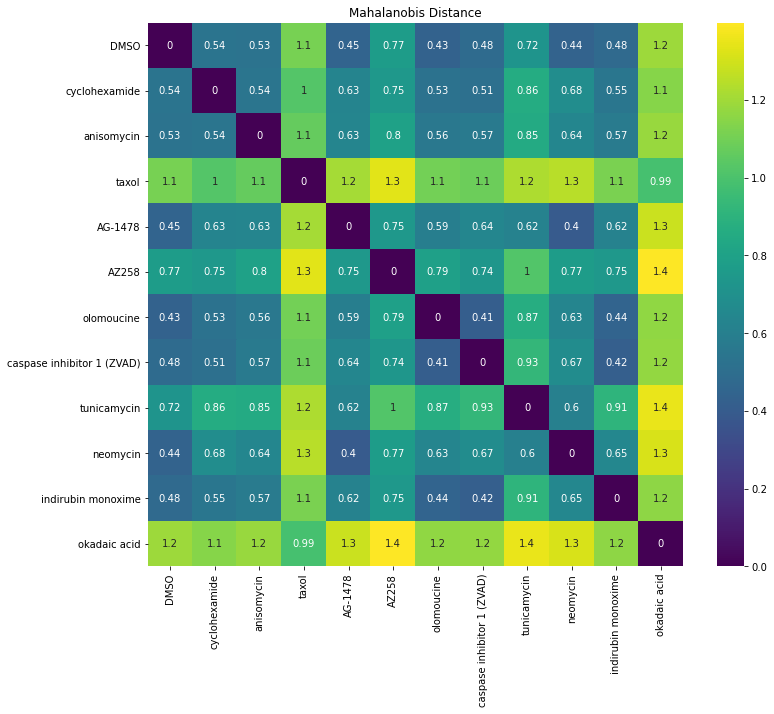

In [23]:
plt.figure(figsize=(12,10))
sns.heatmap(dist_matrix, xticklabels=comp_list, yticklabels=comp_list, cmap=plt.cm.viridis, annot=True)
plt.title('Mahalanobis Distance')
plt.show()

In [24]:
def std_matrix(x):
    sigma = np.eye(len(x[0]))
    std = np.std(x, axis=0)
    np.fill_diagonal(sigma, std)
    return sigma

def kl_distance(x, y):
    sigma_x = std_matrix(x)
    sigma_y = std_matrix(y)
    d = len(x[0])
    mu_x = np.mean(x, axis=0)
    mu_y = np.mean(y, axis=0)
    
    kl = np.trace(np.linalg.inv(sigma_y) @ sigma_x)
    kl += ((mu_y - mu_x).T @ np.linalg.inv(sigma_y) @ (mu_y - mu_x)) - d
    kl += np.log(np.linalg.det(sigma_y) / np.linalg.det(sigma_x))
    return kl

def symmetric_kl(x, y):
    kl_xy = kl_distance(x, y)
    kl_yx = kl_distance(y, x)
    
    return 0.5 * (kl_xy + kl_yx)

In [25]:
kldist_matrix = np.empty(0)
i = 0
for x in comp_list:
    distances = []
    selected_comps = compound_folder[compound_folder['Image_Metadata_Compound'] == x]
    is_compound = np.isin(test_labels, selected_comps.id.values)
    comp_x = test_z[is_compound].numpy()
    for y in comp_list:
        selected_comps = compound_folder[compound_folder['Image_Metadata_Compound'] == y]
        is_compound = np.isin(test_labels, selected_comps.id.values)
        comp_y = test_z[is_compound].numpy()
        distances.append(symmetric_kl(comp_x, comp_y))
        
    dist_array = np.array(distances)
    if kldist_matrix.any():
        kldist_matrix = np.vstack((kldist_matrix, dist_array))
    else:
        kldist_matrix = dist_array
kldist_matrix.shape

(12, 12)

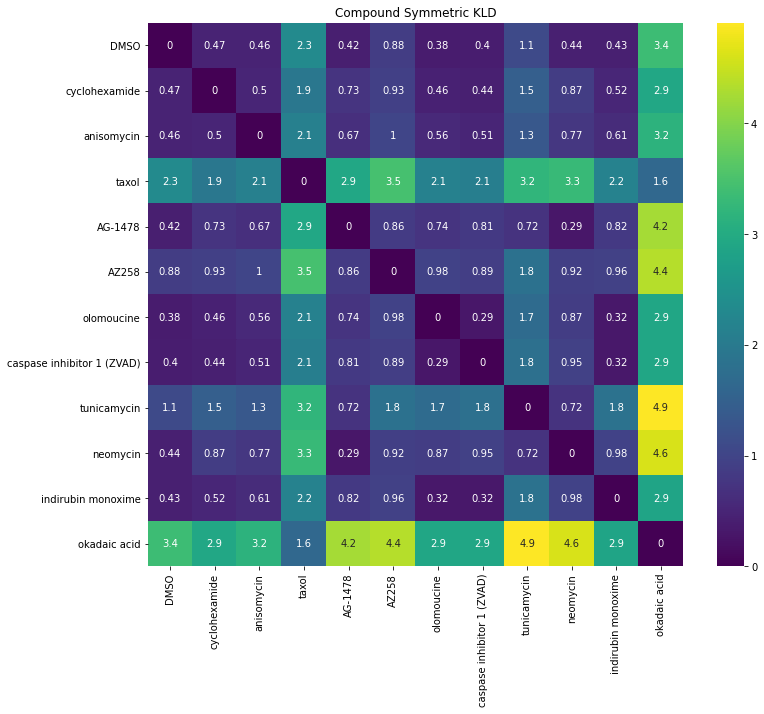

In [26]:
plt.figure(figsize=(12,10))
sns.heatmap(kldist_matrix, xticklabels=comp_list, yticklabels=comp_list, cmap=plt.cm.viridis, annot=True)
plt.title('Compound Symmetric KLD')
plt.show()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


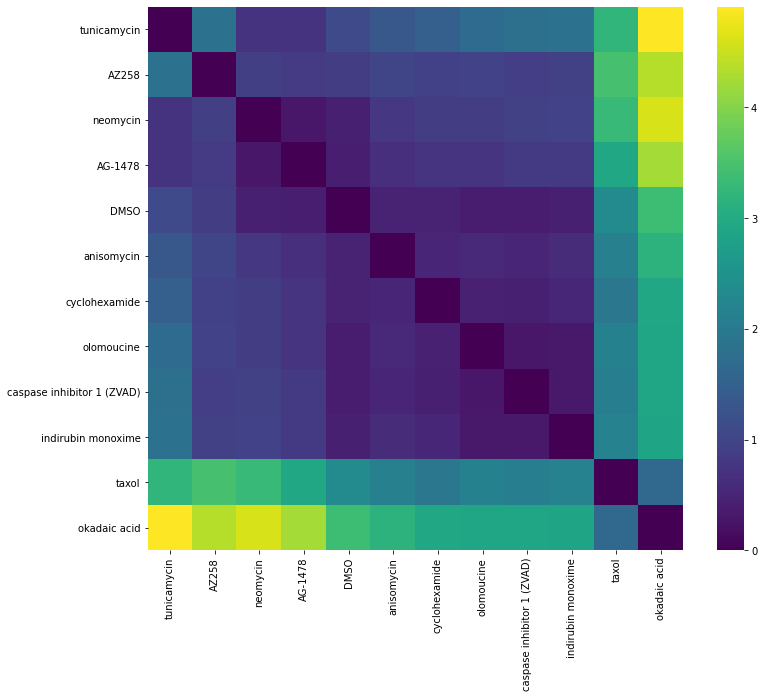

In [27]:
import scipy.cluster.hierarchy as sch
plt.figure(figsize=(12,10))
Y = sch.linkage(kldist_matrix, method='centroid', optimal_ordering=True)
Z = sch.dendrogram(Y, orientation='left', no_plot=True)

# Plot distance matrix.
labels = comp_list[Z['leaves']]
D = kldist_matrix
index = Z['leaves']
D = D[index,:]
D = D[:,index]
sns.heatmap(D, xticklabels=labels, yticklabels=labels, cmap=plt.cm.viridis)



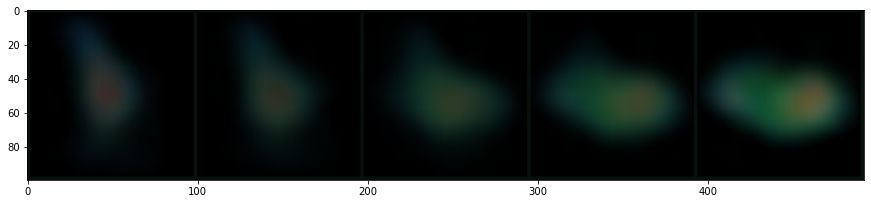

In [28]:
model.eval()
idx = np.argmax(kldist_matrix)
s, _ = kldist_matrix.shape
comp_a = idx // s
comp_b = idx % s
comp_a = comp_list[comp_a]
comp_b = comp_list[comp_b]

selected_comps = compound_folder[compound_folder['Image_Metadata_Compound'] == comp_a]
is_compound = np.isin(test_labels, selected_comps.id.values)
comp_arr_a = test_z[is_compound].numpy()

selected_comps = compound_folder[compound_folder['Image_Metadata_Compound'] == comp_b]
is_compound = np.isin(test_labels, selected_comps.id.values)
comp_arr_b = test_z[is_compound].numpy()

np.random.seed(22)
base_idx = np.random.randint(len(comp_arr_a))
target_idx = np.random.randint(len(comp_arr_b))

base = torch.from_numpy(comp_arr_a[base_idx:base_idx+1]).to(device)
target = torch.from_numpy(comp_arr_b[target_idx:target_idx+1]).to(device)

diff = target - base
recon_25 = model.decode(base + diff*0.25)
recon_50 = model.decode(base + diff*0.50)
recon_75 = model.decode(base + diff*0.75)
base = model.decode(base)
target = model.decode(target)
interpolation = torch.cat((base, recon_25, recon_50, recon_75, target), dim=0).cpu().detach()
plt.figure(figsize=(15,15))
imshow(torchvision.utils.make_grid(interpolation))

In [29]:
test_compounds = []

for label in test_labels:
    compound = compound_folder[compound_folder.id == label.item()]['Image_Metadata_Compound'].values[0]
    test_compounds.append(compound)

test_compounds

['DMSO',
 'caspase inhibitor 1 (ZVAD)',
 'caspase inhibitor 1 (ZVAD)',
 'olomoucine',
 'caspase inhibitor 1 (ZVAD)',
 'neomycin',
 'DMSO',
 'tunicamycin',
 'neomycin',
 'tunicamycin',
 'tunicamycin',
 'anisomycin',
 'caspase inhibitor 1 (ZVAD)',
 'olomoucine',
 'caspase inhibitor 1 (ZVAD)',
 'taxol',
 'neomycin',
 'cyclohexamide',
 'indirubin monoxime',
 'okadaic acid',
 'indirubin monoxime',
 'DMSO',
 'anisomycin',
 'AZ258',
 'cyclohexamide',
 'neomycin',
 'DMSO',
 'anisomycin',
 'indirubin monoxime',
 'neomycin',
 'AG-1478',
 'AG-1478',
 'okadaic acid',
 'neomycin',
 'indirubin monoxime',
 'AG-1478',
 'neomycin',
 'AG-1478',
 'okadaic acid',
 'caspase inhibitor 1 (ZVAD)',
 'tunicamycin',
 'caspase inhibitor 1 (ZVAD)',
 'indirubin monoxime',
 'indirubin monoxime',
 'AG-1478',
 'okadaic acid',
 'cyclohexamide',
 'AG-1478',
 'cyclohexamide',
 'neomycin',
 'DMSO',
 'olomoucine',
 'AZ258',
 'tunicamycin',
 'indirubin monoxime',
 'indirubin monoxime',
 'neomycin',
 'DMSO',
 'caspase inhibi

In [32]:
leaves = Z['leaves']
hc_comps = comp_list[leaves]
hue_df = pd.DataFrame(test_compounds, columns=['comp'])
hue_df['hue'] = -1
for idx, item in enumerate(hc_comps):
    hue_df.loc[hue_df.comp == item, 'hue'] = idx
hue_df

,comp,hue
0,DMSO,4
1,caspase inhibitor 1 (ZVAD),8
2,caspase inhibitor 1 (ZVAD),8
3,olomoucine,7
4,caspase inhibitor 1 (ZVAD),8
...,...,...
30311,neomycin,2
30312,caspase inhibitor 1 (ZVAD),8
30313,AG-1478,3
30314,AG-1478,3


In [33]:
compound_folder['Image_Metadata_Compound'].value_counts()

DMSO                          100
neomycin                       89
indirubin monoxime             82
caspase inhibitor 1 (ZVAD)     82
olomoucine                     82
tunicamycin                    78
AG-1478                        76
cyclohexamide                  72
AZ258                          69
okadaic acid                   67
taxol                          58
anisomycin                     52
Name: Image_Metadata_Compound, dtype: int64

In [34]:
dmso = compound_folder[compound_folder['Image_Metadata_Compound'] == 'DMSO']
dmso

,Image_FileName_DAPI,Image_Metadata_Compound,id
12408,B02_s1_w16F89C55C-7808-4136-82E4-E066F8E3CB10,DMSO,0
12504,B02_s1_w1B1A7ADEA-8896-4C7D-8C63-663265374B72,DMSO,1
12456,B02_s1_w1D9CCD4E7-65E8-4426-9178-A955453164C5,DMSO,2
12432,B02_s1_w1E35EFE33-AB1C-4DB4-996B-D224E67F5C72,DMSO,3
12480,B02_s1_w1EA42BBDC-A8FA-44AB-A9B7-DA330F81E2A2,DMSO,4
...,...,...,...
12499,F11_s4_w1423324D8-4DCA-4A5B-80F9-CEAA52425281,DMSO,902
12475,F11_s4_w15D4C00DF-F9F2-4C86-943F-52A5F80508D2,DMSO,903
12403,F11_s4_w16E9FF291-D2C4-48E3-B076-CBD2A71FE95D,DMSO,904
12523,F11_s4_w1AA58D79B-0601-443D-A27C-7E5B61E4DB1C,DMSO,905


In [35]:
len(test_labels)

30316

In [36]:
categorical_labels = pd.Series(test_compounds, dtype="category")
categorical_labels

0                              DMSO
1        caspase inhibitor 1 (ZVAD)
2        caspase inhibitor 1 (ZVAD)
3                        olomoucine
4        caspase inhibitor 1 (ZVAD)
                    ...            
30311                      neomycin
30312    caspase inhibitor 1 (ZVAD)
30313                       AG-1478
30314                       AG-1478
30315                    olomoucine
Length: 30316, dtype: category
Categories (12, object): [AG-1478, AZ258, DMSO, anisomycin, ..., okadaic acid, olomoucine, taxol, tunicamycin]

In [37]:
import umap
reducer = umap.UMAP( random_state=22)
z_2d = reducer.fit_transform(test_z)

In [38]:
from ipywidgets import widgets, interactive

# Make a dropdown to select the Area, or "All"
comp = widgets.Dropdown(
    options=['All'] + list(compound_folder['Image_Metadata_Compound'].unique()),
    value='All',
    description='Compound:',
)

def plotit(compound):
    x = z_2d[:,0]
    y = z_2d[:,1]
    title = 'All Compounds UMAP'
    if compound != 'All':
        selected_comps = compound_folder[compound_folder['Image_Metadata_Compound'] == compound]
        is_compound = np.isin(test_labels, selected_comps.id.values)
        x = x[is_compound]
        y = y[is_compound]
        title = compound + ' UMAP'
    plt.figure(figsize=(10,10))
    plt.title(title)
    sns.scatterplot(x, y, alpha=0.7, size=1, palette=sns.cubehelix_palette(1))
    plt.show()
interactive(plotit, compound=comp)

interactive(children=(Dropdown(description='Compound:', options=('All', 'DMSO', 'cyclohexamide', 'anisomycin',…

In [39]:
from ipywidgets import widgets, interactive

# Make a dropdown to select the Area, or "All"
comp = widgets.Dropdown(
    options=['All'] + list(compound_folder['Image_Metadata_Compound'].unique()),
    value='All',
    description='Compound:',
)

def plotit(compound):
    x = z_2d[:,0]
    y = z_2d[:,1]
    title = 'All Compounds Density Plot'
    if compound != 'All':
        selected_comps = compound_folder[compound_folder['Image_Metadata_Compound'] == compound]
        is_compound = np.isin(test_labels, selected_comps.id.values)
        x = x[is_compound]
        y = y[is_compound]
        title = compound + ' Density Plot'
    plt.figure(figsize=(10,10))
    plt.title(title)
    sns.kdeplot(x, y, legend=True, shade=True, cmap=sns.cubehelix_palette(light=1, as_cmap=True))
    plt.show()
interactive(plotit, compound=comp)

interactive(children=(Dropdown(description='Compound:', options=('All', 'DMSO', 'cyclohexamide', 'anisomycin',…

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(z_2d[:,0], z_2d[:,1], alpha=0.5,size=1, hue=hue_df.hue, palette=sns.hls_palette(12))
plt.title('All Compounds')
plt.show()

30316


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


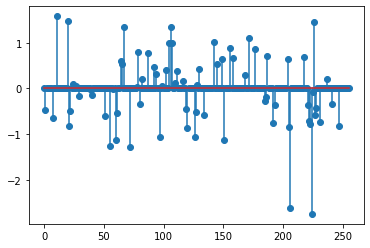

tensor(125)

In [90]:
comp_list
print(len(test_z))
y = test_z[2501]
x = np.arange(256)
plt.figure(figsize=(6,4))
plt.stem(x, y)
plt.show()
sum(y == 0)

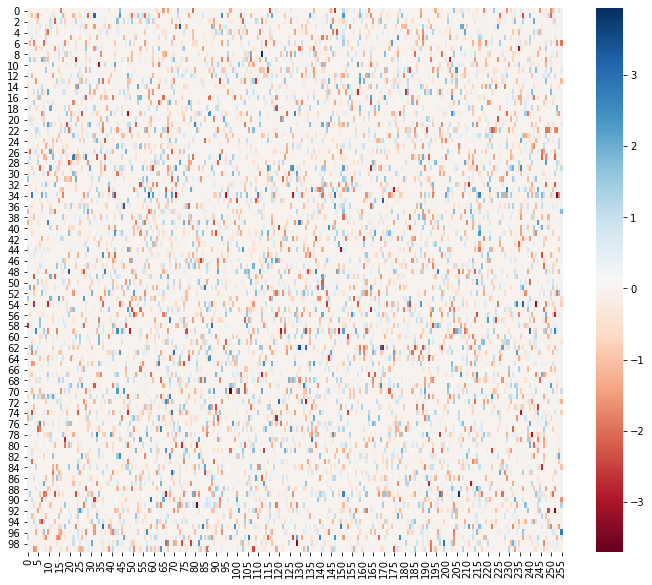

In [73]:
z_slice = test_z[:100]
plt.figure(figsize=(12,10))
sns.heatmap(z_slice, cmap=plt.cm.RdBu)

In [74]:
mean_vector = []
std_matrix = []
for compound in comp_list:
    selected_comps = compound_folder[compound_folder['Image_Metadata_Compound'] == compound]
    is_compound = np.isin(test_labels, selected_comps.id.values)
    z_np = test_z[is_compound].numpy()
    mean = z_np.mean(axis=0)
    std = z_np.std(axis=0)
    mean_vector.append(mean)
    std_matrix.append(std)
mean_vector = np.asarray(mean_vector)
std_matrix = np.asarray(std_matrix)

In [75]:
np.min(std_matrix)

0.46469173

In [1]:
np.mean(np.std(test_z[:1000].numpy(), axis=0))

NameError: name 'np' is not defined

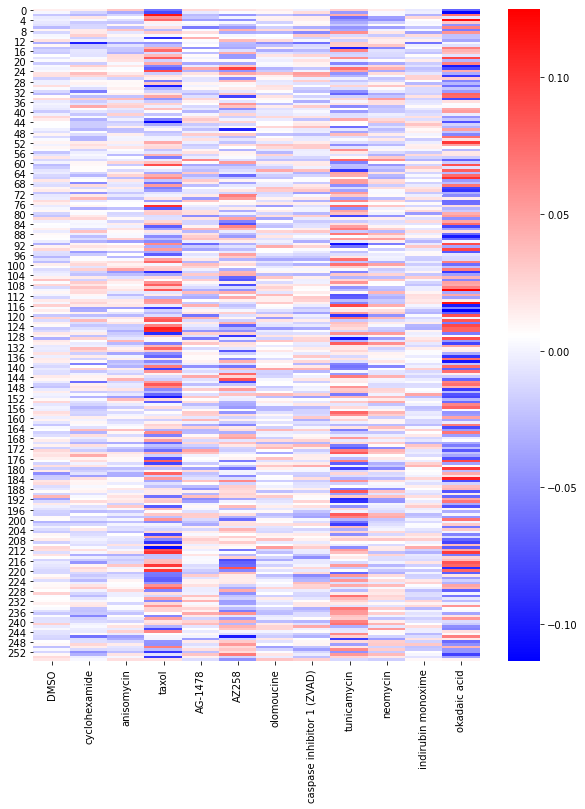

In [77]:
plt.figure(figsize=(10,12))
sns.heatmap(mean_vector.T, cmap=plt.cm.bwr, xticklabels=comp_list)

### Experimental Cells
Please ignore

In [ ]:
trial = test_z[2222]

x_tick = model.decode(trial.to(device)).cpu().detach()[0]
inp = x_tick.numpy().transpose((1, 2, 0))
mean = np.array([0.0302, 0.0660, 0.0518])
std = np.array([0.0633, 0.0974, 0.0766])
inp = std * inp + mean
inp = np.clip(inp, 0, 1)

N = 96
img = np.empty((N,N), dtype=np.uint32)
view = img.view(dtype=np.uint8).reshape((N, N, 4))
view[:,:,0] = inp[:,:,0] * 255 # copy red channel
view[:,:,1] = inp[:,:,1] * 255 # copy blue channel
view[:,:,2] = inp[:,:,2] * 255 # copy green channel
view[:,:,3] = 255


output_notebook()
p = figure(title='Image', height=96*4, width=96*4)
p.image_rgba(image=[img],x=0,y=0, dw=96, dh=96)
show(p)

In [41]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import Slider
from bokeh.layouts import column
from bokeh.layouts import row
from bokeh.application.handlers import FunctionHandler
from bokeh.application import Application
from bokeh.models import ColumnDataSource
import numpy as np

def get_bokeh_image(z):
    x_hat = model.decode(z.to(device)).cpu().detach()[0]
    inp = x_hat.numpy().transpose((1, 2, 0))
    mean = np.array([0.0302, 0.0660, 0.0518])
    std = np.array([0.0633, 0.0974, 0.0766])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    N = 96
    img = np.empty((N,N), dtype=np.uint32)
    view = img.view(dtype=np.uint8).reshape((N, N, 4))
    view[:,:,0] = inp[:,:,0] * 255 # copy red channel
    view[:,:,1] = inp[:,:,1] * 255 # copy blue channel
    view[:,:,2] = inp[:,:,2] * 255 # copy green channel
    view[:,:,3] = 255
    
    return [img]

output_notebook()

z = test_z[2222]
y = z.numpy()
x = np.arange(256)
img = get_bokeh_image(z)

source = ColumnDataSource(data=dict(x=x, y=y))
img_source = ColumnDataSource(data=dict(img=img))

def modify_doc(doc):
    stem = figure(title="Stem plot", y_range=[-3, 3], x_range=[-1,256], tools='hover')
    stem.segment(x0='x', x1='x', y0=0, y1='y', source=source, color='green')
    stem.circle(x='x', y='y', source=source, size=5, color='orange')
    
    cell = figure(title='Image', height=96*4, width=96*4)
    cell.image_rgba(image='img', source=img_source,x=0,y=0, dw=96, dh=96)

    def update_value(attr, old, new):
        selected_z = z_slider.value
        value = val_slider.value
        y[selected_z] = value
        source.data = dict(x=x, y=y)
        recon = get_bokeh_image(torch.tensor(y))
        img_source.data = dict(img=recon)
        
    def update_dim(attr, old, new):
        selected_z = z_slider.value
        val_slider.value = y[selected_z]
        

    z_slider = Slider(start=0, end=255, value=0, step=1, title="Z selected")
    val_slider = Slider(start=-5, end=5, value=y[0], step=0.1, title='Dimension Value')
    z_slider.on_change('value', update_dim)
    val_slider.on_change('value', update_value)

    controls = column(z_slider, val_slider)
    layout = row(stem, cell)
    layout = column(controls, layout)
    #layout = column(controls, stem)
    doc.add_root(layout)
handler = FunctionHandler(modify_doc)
app = Application(handler)
show(app)

Loading BokehJS ...

In [147]:
x_tick[0][1]

tensor([-0.4800, -0.4756, -0.4834, -0.4790, -0.4929, -0.4898, -0.4932, -0.4878,
        -0.4825, -0.4851, -0.4809, -0.4811, -0.4775, -0.4788, -0.4794, -0.4919,
        -0.4902, -0.4922, -0.4932, -0.4895, -0.4914, -0.4884, -0.4877, -0.4869,
        -0.4834, -0.4774, -0.4754, -0.4702, -0.4676, -0.4668, -0.4666, -0.4609,
        -0.4607, -0.4603, -0.4584, -0.4639, -0.4626, -0.4661, -0.4677, -0.4711,
        -0.4771, -0.4845, -0.4861, -0.4843, -0.4878, -0.4850, -0.4829, -0.4812,
        -0.4755, -0.4816, -0.4804, -0.4795, -0.4788, -0.4831, -0.4825, -0.4865,
        -0.4877, -0.4798, -0.4831, -0.4830, -0.4877, -0.4831, -0.4862, -0.4817,
        -0.4851, -0.4927, -0.4940, -0.4986, -0.4963, -0.5023, -0.5012, -0.5077,
        -0.5058, -0.5029, -0.5041, -0.5043, -0.5012, -0.4962, -0.4984, -0.4981,
        -0.4993, -0.4991, -0.4953, -0.4972, -0.4957, -0.5025, -0.5010, -0.5019,
        -0.5079, -0.4921, -0.4894, -0.4804, -0.4782, -0.4669, -0.4560, -0.4567])

In [109]:
loss, mse, kld = loss_function(recon, x, mu, logvar)
kld

NameError: name 'recon' is not defined

ERROR:bokeh.server.protocol_handler:error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': '14560'}, 'attr': 'value', 'new': 0.2999999999999998}], 'references': []} 
 error: ValueError('dictionary update sequence element #0 has length 96; 2 is required')
Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\bokeh\server\protocol_handler.py", line 90, in handle
    work = await handler(message, connection)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 67, in _needs_document_lock_wrapper
    result = func(self, *args, **kwargs)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 261, in _handle_patch
    message.apply_to_document(self.document, self)
  File "D:\Anaconda3\lib\site-packages\bokeh\protocol\messages\patch_doc.py", line 100, in apply_to_document
    doc._with_self_as_curdoc(lambda: doc.apply_json_patch(self.content, setter))
  File "D:\Anaconda3\lib\site-p

ERROR:bokeh.server.protocol_handler:error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': '14560'}, 'attr': 'value', 'new': 1.2000000000000002}], 'references': []} 
 error: ValueError('dictionary update sequence element #0 has length 96; 2 is required')
Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\bokeh\server\protocol_handler.py", line 90, in handle
    work = await handler(message, connection)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 67, in _needs_document_lock_wrapper
    result = func(self, *args, **kwargs)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 261, in _handle_patch
    message.apply_to_document(self.document, self)
  File "D:\Anaconda3\lib\site-packages\bokeh\protocol\messages\patch_doc.py", line 100, in apply_to_document
    doc._with_self_as_curdoc(lambda: doc.apply_json_patch(self.content, setter))
  File "D:\Anaconda3\lib\site-p

ERROR:bokeh.server.protocol_handler:error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': '14560'}, 'attr': 'value', 'new': 1.5999999999999996}], 'references': []} 
 error: ValueError('dictionary update sequence element #0 has length 96; 2 is required')
Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\bokeh\server\protocol_handler.py", line 90, in handle
    work = await handler(message, connection)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 67, in _needs_document_lock_wrapper
    result = func(self, *args, **kwargs)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 261, in _handle_patch
    message.apply_to_document(self.document, self)
  File "D:\Anaconda3\lib\site-packages\bokeh\protocol\messages\patch_doc.py", line 100, in apply_to_document
    doc._with_self_as_curdoc(lambda: doc.apply_json_patch(self.content, setter))
  File "D:\Anaconda3\lib\site-p

ERROR:bokeh.server.protocol_handler:error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': '14560'}, 'attr': 'value', 'new': 2}], 'references': []} 
 error: ValueError('dictionary update sequence element #0 has length 96; 2 is required')
Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\bokeh\server\protocol_handler.py", line 90, in handle
    work = await handler(message, connection)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 67, in _needs_document_lock_wrapper
    result = func(self, *args, **kwargs)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 261, in _handle_patch
    message.apply_to_document(self.document, self)
  File "D:\Anaconda3\lib\site-packages\bokeh\protocol\messages\patch_doc.py", line 100, in apply_to_document
    doc._with_self_as_curdoc(lambda: doc.apply_json_patch(self.content, setter))
  File "D:\Anaconda3\lib\site-packages\bokeh\doc

ERROR:bokeh.server.protocol_handler:error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': '14560'}, 'attr': 'value', 'new': 2.3}], 'references': []} 
 error: ValueError('dictionary update sequence element #0 has length 96; 2 is required')
Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\bokeh\server\protocol_handler.py", line 90, in handle
    work = await handler(message, connection)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 67, in _needs_document_lock_wrapper
    result = func(self, *args, **kwargs)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 261, in _handle_patch
    message.apply_to_document(self.document, self)
  File "D:\Anaconda3\lib\site-packages\bokeh\protocol\messages\patch_doc.py", line 100, in apply_to_document
    doc._with_self_as_curdoc(lambda: doc.apply_json_patch(self.content, setter))
  File "D:\Anaconda3\lib\site-packages\bokeh\d

ERROR:bokeh.server.protocol_handler:error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': '14560'}, 'attr': 'value', 'new': 2.5999999999999996}], 'references': []} 
 error: ValueError('dictionary update sequence element #0 has length 96; 2 is required')
Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\bokeh\server\protocol_handler.py", line 90, in handle
    work = await handler(message, connection)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 67, in _needs_document_lock_wrapper
    result = func(self, *args, **kwargs)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 261, in _handle_patch
    message.apply_to_document(self.document, self)
  File "D:\Anaconda3\lib\site-packages\bokeh\protocol\messages\patch_doc.py", line 100, in apply_to_document
    doc._with_self_as_curdoc(lambda: doc.apply_json_patch(self.content, setter))
  File "D:\Anaconda3\lib\site-p

ERROR:bokeh.server.protocol_handler:error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': '14560'}, 'attr': 'value', 'new': 3.0999999999999996}], 'references': []} 
 error: ValueError('dictionary update sequence element #0 has length 96; 2 is required')
Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\bokeh\server\protocol_handler.py", line 90, in handle
    work = await handler(message, connection)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 67, in _needs_document_lock_wrapper
    result = func(self, *args, **kwargs)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 261, in _handle_patch
    message.apply_to_document(self.document, self)
  File "D:\Anaconda3\lib\site-packages\bokeh\protocol\messages\patch_doc.py", line 100, in apply_to_document
    doc._with_self_as_curdoc(lambda: doc.apply_json_patch(self.content, setter))
  File "D:\Anaconda3\lib\site-p

ERROR:bokeh.server.protocol_handler:error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': '14560'}, 'attr': 'value', 'new': 3}], 'references': []} 
 error: ValueError('dictionary update sequence element #0 has length 96; 2 is required')
Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\bokeh\server\protocol_handler.py", line 90, in handle
    work = await handler(message, connection)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 67, in _needs_document_lock_wrapper
    result = func(self, *args, **kwargs)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 261, in _handle_patch
    message.apply_to_document(self.document, self)
  File "D:\Anaconda3\lib\site-packages\bokeh\protocol\messages\patch_doc.py", line 100, in apply_to_document
    doc._with_self_as_curdoc(lambda: doc.apply_json_patch(self.content, setter))
  File "D:\Anaconda3\lib\site-packages\bokeh\doc

ERROR:bokeh.server.protocol_handler:error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': '14560'}, 'attr': 'value', 'new': 2.3}], 'references': []} 
 error: ValueError('dictionary update sequence element #0 has length 96; 2 is required')
Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\bokeh\server\protocol_handler.py", line 90, in handle
    work = await handler(message, connection)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 67, in _needs_document_lock_wrapper
    result = func(self, *args, **kwargs)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 261, in _handle_patch
    message.apply_to_document(self.document, self)
  File "D:\Anaconda3\lib\site-packages\bokeh\protocol\messages\patch_doc.py", line 100, in apply_to_document
    doc._with_self_as_curdoc(lambda: doc.apply_json_patch(self.content, setter))
  File "D:\Anaconda3\lib\site-packages\bokeh\d

ERROR:bokeh.server.protocol_handler:error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': '14560'}, 'attr': 'value', 'new': 1.5999999999999996}], 'references': []} 
 error: ValueError('dictionary update sequence element #0 has length 96; 2 is required')
Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\bokeh\server\protocol_handler.py", line 90, in handle
    work = await handler(message, connection)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 67, in _needs_document_lock_wrapper
    result = func(self, *args, **kwargs)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 261, in _handle_patch
    message.apply_to_document(self.document, self)
  File "D:\Anaconda3\lib\site-packages\bokeh\protocol\messages\patch_doc.py", line 100, in apply_to_document
    doc._with_self_as_curdoc(lambda: doc.apply_json_patch(self.content, setter))
  File "D:\Anaconda3\lib\site-p

ERROR:bokeh.server.protocol_handler:error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': '14560'}, 'attr': 'value', 'new': 0.9000000000000004}], 'references': []} 
 error: ValueError('dictionary update sequence element #0 has length 96; 2 is required')
Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\bokeh\server\protocol_handler.py", line 90, in handle
    work = await handler(message, connection)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 67, in _needs_document_lock_wrapper
    result = func(self, *args, **kwargs)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 261, in _handle_patch
    message.apply_to_document(self.document, self)
  File "D:\Anaconda3\lib\site-packages\bokeh\protocol\messages\patch_doc.py", line 100, in apply_to_document
    doc._with_self_as_curdoc(lambda: doc.apply_json_patch(self.content, setter))
  File "D:\Anaconda3\lib\site-p

ERROR:bokeh.server.protocol_handler:error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': '14560'}, 'attr': 'value', 'new': 0}], 'references': []} 
 error: ValueError('dictionary update sequence element #0 has length 96; 2 is required')
Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\bokeh\server\protocol_handler.py", line 90, in handle
    work = await handler(message, connection)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 67, in _needs_document_lock_wrapper
    result = func(self, *args, **kwargs)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 261, in _handle_patch
    message.apply_to_document(self.document, self)
  File "D:\Anaconda3\lib\site-packages\bokeh\protocol\messages\patch_doc.py", line 100, in apply_to_document
    doc._with_self_as_curdoc(lambda: doc.apply_json_patch(self.content, setter))
  File "D:\Anaconda3\lib\site-packages\bokeh\doc

ERROR:bokeh.server.protocol_handler:error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': '14560'}, 'attr': 'value', 'new': -0.7000000000000002}], 'references': []} 
 error: ValueError('dictionary update sequence element #0 has length 96; 2 is required')
Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\bokeh\server\protocol_handler.py", line 90, in handle
    work = await handler(message, connection)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 67, in _needs_document_lock_wrapper
    result = func(self, *args, **kwargs)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 261, in _handle_patch
    message.apply_to_document(self.document, self)
  File "D:\Anaconda3\lib\site-packages\bokeh\protocol\messages\patch_doc.py", line 100, in apply_to_document
    doc._with_self_as_curdoc(lambda: doc.apply_json_patch(self.content, setter))
  File "D:\Anaconda3\lib\site-

ERROR:bokeh.server.protocol_handler:error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': '14560'}, 'attr': 'value', 'new': -1.7000000000000002}], 'references': []} 
 error: ValueError('dictionary update sequence element #0 has length 96; 2 is required')
Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\bokeh\server\protocol_handler.py", line 90, in handle
    work = await handler(message, connection)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 67, in _needs_document_lock_wrapper
    result = func(self, *args, **kwargs)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 261, in _handle_patch
    message.apply_to_document(self.document, self)
  File "D:\Anaconda3\lib\site-packages\bokeh\protocol\messages\patch_doc.py", line 100, in apply_to_document
    doc._with_self_as_curdoc(lambda: doc.apply_json_patch(self.content, setter))
  File "D:\Anaconda3\lib\site-

ERROR:bokeh.server.protocol_handler:error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': '14560'}, 'attr': 'value', 'new': -2.3}], 'references': []} 
 error: ValueError('dictionary update sequence element #0 has length 96; 2 is required')
Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\bokeh\server\protocol_handler.py", line 90, in handle
    work = await handler(message, connection)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 67, in _needs_document_lock_wrapper
    result = func(self, *args, **kwargs)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 261, in _handle_patch
    message.apply_to_document(self.document, self)
  File "D:\Anaconda3\lib\site-packages\bokeh\protocol\messages\patch_doc.py", line 100, in apply_to_document
    doc._with_self_as_curdoc(lambda: doc.apply_json_patch(self.content, setter))
  File "D:\Anaconda3\lib\site-packages\bokeh\

ERROR:bokeh.server.protocol_handler:error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': '14560'}, 'attr': 'value', 'new': -3.2}], 'references': []} 
 error: ValueError('dictionary update sequence element #0 has length 96; 2 is required')
Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\bokeh\server\protocol_handler.py", line 90, in handle
    work = await handler(message, connection)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 67, in _needs_document_lock_wrapper
    result = func(self, *args, **kwargs)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 261, in _handle_patch
    message.apply_to_document(self.document, self)
  File "D:\Anaconda3\lib\site-packages\bokeh\protocol\messages\patch_doc.py", line 100, in apply_to_document
    doc._with_self_as_curdoc(lambda: doc.apply_json_patch(self.content, setter))
  File "D:\Anaconda3\lib\site-packages\bokeh\

ERROR:bokeh.server.protocol_handler:error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': '14560'}, 'attr': 'value', 'new': -4}], 'references': []} 
 error: ValueError('dictionary update sequence element #0 has length 96; 2 is required')
Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\bokeh\server\protocol_handler.py", line 90, in handle
    work = await handler(message, connection)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 67, in _needs_document_lock_wrapper
    result = func(self, *args, **kwargs)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 261, in _handle_patch
    message.apply_to_document(self.document, self)
  File "D:\Anaconda3\lib\site-packages\bokeh\protocol\messages\patch_doc.py", line 100, in apply_to_document
    doc._with_self_as_curdoc(lambda: doc.apply_json_patch(self.content, setter))
  File "D:\Anaconda3\lib\site-packages\bokeh\do

ERROR:bokeh.server.protocol_handler:error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': '14560'}, 'attr': 'value', 'new': -4.4}], 'references': []} 
 error: ValueError('dictionary update sequence element #0 has length 96; 2 is required')
Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\bokeh\server\protocol_handler.py", line 90, in handle
    work = await handler(message, connection)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 67, in _needs_document_lock_wrapper
    result = func(self, *args, **kwargs)
  File "D:\Anaconda3\lib\site-packages\bokeh\server\session.py", line 261, in _handle_patch
    message.apply_to_document(self.document, self)
  File "D:\Anaconda3\lib\site-packages\bokeh\protocol\messages\patch_doc.py", line 100, in apply_to_document
    doc._with_self_as_curdoc(lambda: doc.apply_json_patch(self.content, setter))
  File "D:\Anaconda3\lib\site-packages\bokeh\

In [ ]:
torch.mean((-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)))

In [ ]:
torch.sum(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))

In [ ]:
-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

In [ ]:
mse

In [ ]:
# MSE
torch.mean(torch.mean((x - recon).pow(2), dim=(1,2,3)))

In [ ]:
# Mean of sum of squared errors
torch.mean(torch.sum((x - recon).pow(2), dim=(1,2,3)))

In [ ]:
torch.sum((x - recon).pow(2), dim=(1,2,3))

In [ ]:
recon

In [ ]:
F.mse_loss(recon, x, reduction='sum')

# Extra

The cell below calculates the MEAN and STD of the data set so it can be normalized properly

In [ ]:
image_dataset = datasets.ImageFolder(data_dir, transform=transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]))

loader = data.DataLoader(
    image_dataset,
    batch_size=128,
    num_workers=0,
    pin_memory=True,
    shuffle=False
)


mean = 0.
std = 0.
nb_samples = 0.
for dat, _ in loader:
    batch_samples = dat.size(0)
    dat = dat.view(batch_samples, dat.size(1), -1)
    mean += dat.mean(2).sum(0)
    std += dat.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples
print("mean: ", mean)
print("std: ", std)